# Fibres of Failure
## Aims
Today I intend to build a simple Fibres of Failure model to improve the random forest classifier from yesterday.
As an initial design, I will build a Random Forest Regressor on a set of compounds that act against a specific target. Then, I will do some TDA on them using chemical similarity as a distance metric, and lens by error in the random forest regressor. Hopefully this will spot some specific failure modes, and we can correct for the error in prediction for the regressor.

## Pitfalls
1. Watch out -- this is extremely dependent on the random seed, so R^2 values can range from 0.1 to 0.5 for the regressor.

In [19]:
import pickle
import sys

import scipy
import hdbscan

import rdkit
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem
from rdkit.Chem import DataStructs

import numpy as np
import pandas as pd
import kmapper as km
import matplotlib.pyplot as plt

import sklearn.ensemble

from IPython.display import SVG, IFrame

How do we choose to split the data? If we choose a training set up to specific year and validate on newer compounds, we get a worse score than if we randomly select a training set from the data. This is probably because newer compounds have features not seen in the training set as synthetic chemistry progresses.

In [27]:
ACTIVITY_CUTOFF = 5.0
DESIRED_TARGETS = ["CHEMBL240"]
MAPPER_TARGETS = DESIRED_TARGETS
FP_SIZE = 2048
RANDOM_STATE = 2019
VALIDATE_BY_YEAR = False
if VALIDATE_BY_YEAR:
    YEAR_CUTOFF = 2013
else:
    VALIDATE_FRACTION = 0.15

In [28]:
with open("../data/processed/curated_set_with_publication_year.pd.pkl", "rb") as infile:
    df = pickle.load(infile)

In [29]:
df = df[np.logical_or.reduce([df["TGT_CHEMBL_ID"] == tgt for tgt in DESIRED_TARGETS])]
if VALIDATE_BY_YEAR:
    training_df = df[df["DOC_YEAR"] < YEAR_CUTOFF]
    validation_df = df[df["DOC_YEAR"] >= YEAR_CUTOFF]
else:
    df = sklearn.utils.shuffle(df, random_state=RANDOM_STATE)
    split_point = int(df.shape[0] * VALIDATE_FRACTION)
    training_df = df.iloc[split_point:, :]
    validation_df = df.iloc[:split_point, :]

In [30]:
def convert_to_sparse(input_df, use_classes=True):
    n_samples = input_df.shape[0]
    print(n_samples)
    arr = np.empty([n_samples, FP_SIZE], dtype=bool)
    if use_classes:
        is_active = np.empty([n_samples], dtype=bool)
    else:
        is_active = np.empty([n_samples], dtype=np.float64)
    for index, (item, row) in enumerate(input_df.iterrows()):
        fingerprint = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(row["SMILES"]),
                                                                  radius=3,
                                                                  nBits=FP_SIZE)
        DataStructs.ConvertToNumpyArray(fingerprint, arr[index, :])
        if use_classes:
            if row["BIOACT_PCHEMBL_VALUE"] < ACTIVITY_CUTOFF:
                is_active[index] = False
            else:
                is_active[index] = True
        else:
            is_active[index] = row["BIOACT_PCHEMBL_VALUE"]

    observations = scipy.sparse.csc_matrix(arr)
    return observations, is_active

In [31]:
training_observations, training_is_active = convert_to_sparse(training_df, use_classes=False)
validation_observations, validation_is_active = convert_to_sparse(validation_df, use_classes=False)
print(validation_is_active)

3998
705
[4.95  6.21  5.63  4.63  5.07  5.75  6.29  5.08  6.585 5.    5.6   4.64
 5.15  5.14  6.68  5.8   5.    4.69  4.2   5.285 5.13  5.21  5.09  5.32
 4.91  4.7   4.99  4.37  6.03  5.22  5.15  8.61  4.29  6.02  5.47  5.12
 5.26  8.29  5.64  6.2   6.72  6.24  6.6   4.4   4.57  5.62  5.49  5.1
 5.7   5.43  7.34  4.62  5.34  5.    6.2   5.96  5.9   5.09  5.09  5.55
 5.77  4.6   4.9   9.09  4.85  4.55  4.68  5.21  5.39  5.81  5.4   5.12
 4.82  5.41  4.79  5.11  6.28  4.7   5.04  5.2   6.2   4.91  6.18  4.33
 5.1   5.33  4.57  7.01  6.41  4.61  5.7   5.9   6.4   5.3   6.55  4.575
 4.64  5.74  5.34  5.48  5.97  5.8   6.    5.41  6.03  5.03  5.3   5.82
 4.87  4.7   6.16  5.7   5.47  6.05  4.36  7.    5.7   5.92  4.72  6.23
 4.57  6.42  5.1   5.67  5.09  6.05  5.28  4.12  4.72  6.82  5.43  5.39
 5.7   4.8   5.57  5.72  5.62  4.86  5.52  4.86  4.71  5.64  7.96  5.
 5.5   5.99  4.51  4.92  7.21  6.3   5.55  6.38  5.4   5.8   5.92  7.25
 6.02  5.99  5.54  6.1   5.46  4.11  6.55  5.37  4.8   4.

In [40]:
regressor = sklearn.ensemble.RandomForestRegressor(n_estimators=256, criterion="mse", verbose=1, n_jobs=4, bootstrap=True, random_state=RANDOM_STATE)

In [41]:
regressor.fit(training_observations, training_is_active)
regressor.score(validation_observations, validation_is_active)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   14.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 256 out of 256 | elapsed:  1.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 256 out of 256 | elapsed:    0.1s finished


0.5762348147504676

In [42]:
counted = 0
fingerprint_dict = {}
for index, row in df.iterrows():
    drug = row["CMP_CHEMBL_ID"]
    target = row["TGT_CHEMBL_ID"]
    if target in DESIRED_TARGETS:
        fingerprint = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(row["SMILES"]),3)
        fingerprint_dict[drug] = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(row["SMILES"]),3)
    else:
        pass
    counted += 1
    if not counted % 1000:
        print(counted)

1000
2000
3000
4000


In [43]:
chemical_distance = np.zeros([len(df), len(df)])
for index in range(len(df)):
    drug = df.iloc[index]
    fingerprint = fingerprint_dict[drug["CMP_CHEMBL_ID"]]
    if not index % 100:
        print(index)
    for other_index in range(index):
        other_drug = df.iloc[other_index]
        other_fingerprint = fingerprint_dict[other_drug["CMP_CHEMBL_ID"]]
        chem_dissimiliarity = 1.0 - rdkit.DataStructs.TanimotoSimilarity(fingerprint, other_fingerprint)
        chemical_distance[index, other_index] = chem_dissimiliarity
        chemical_distance[other_index, index] = chem_dissimiliarity

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700


In [45]:
with open("2019-04-12-mb-fof-distance.pkl", "wb") as fi:
    pickle.dump(chemical_distance, fi, protocol=pickle.HIGHEST_PROTOCOL)

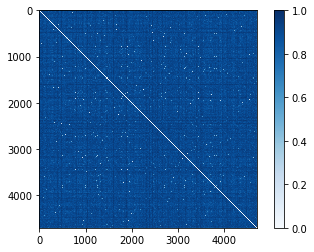

In [44]:
plt.imshow(chemical_distance, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar()

In [46]:
total_observations, ground_truth_activity = convert_to_sparse(df)
predicted_activity = regressor.predict(total_observations)
lens = predicted_activity - ground_truth_activity

4703


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 256 out of 256 | elapsed:    0.1s finished


In [80]:
mapper = km.KeplerMapper(verbose=1)
graph = mapper.map(lens,
                   X=chemical_distance,
                   precomputed=True,
                   cover=km.Cover(n_cubes=10, perc_overlap=0.30),
                   clusterer=hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=5, min_samples=2))
mapper.visualize(graph, path_html="2019-04-12-mb-fibres-of-failure-map.html",
                 title="Fibres of Failure", color_function=np.abs(lens))
IFrame("2019-04-12-mb-fibres-of-failure-map.html", 800, 600)

KeplerMapper(verbose=1)
Mapping on data shaped (4703, 4703) using lens shaped (4703,)

Creating 10 hypercubes.

Created 334 edges and 483 nodes in 0:00:01.181071.
Wrote visualization to: 2019-04-12-mb-fibres-of-failure-map.html


In [81]:
counter = 0
corrections = np.empty_like(lens)
for name, row in validation_df.iterrows():
    fingerprint = fingerprint_dict[row["CMP_CHEMBL_ID"]]
    if (counter % 1 == 0):
        print(counter)
    correction = 0.0
    correction_num = 0
    for node in graph["nodes"]:
        if counter in graph["nodes"][node]:
            # Great, we've found which node it's in.
            # Now we can iterate over the other values          
            for item in graph["nodes"][node]:
                # Only use those that are in the training set.
                if item > int(df.shape[0] * VALIDATE_FRACTION):
                    correction_num += 1
                    other_fp = fingerprint_dict[df.iloc[item]["CMP_CHEMBL_ID"]]
                    arr = np.empty([FP_SIZE])
                    DataStructs.ConvertToNumpyArray(fingerprint, arr)
                    correction += regressor.predict(arr.reshape(1, -1)) - df.iloc[item]["BIOACT_PCHEMBL_VALUE"]
    if correction_num:
        correction = correction / correction_num

    corrections[counter] = correction
    counter += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [74]:
regressor.set_params(verbose=0)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=256, n_jobs=4,
           oob_score=False, random_state=2019, verbose=0, warm_start=False)

In [85]:
corrections = corrections[:len(validation_df)]
predicted_activity = regressor.predict(validation_observations)

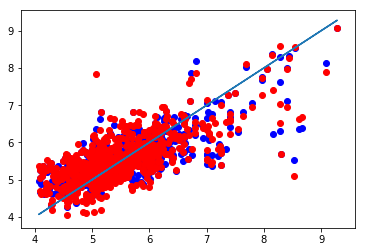

In [89]:
plt.scatter(validation_is_active, predicted_activity, c="blue")
plt.scatter(validation_is_active, predicted_activity + corrections, c="red")
plt.plot(validation_is_active, validation_is_active)
plt.show()

In [97]:
res_sum_sq = ((validation_is_active - predicted_activity) ** 2).sum() 
total_sum_sq = ((validation_is_active - validation_is_active.mean()) ** 2).sum()
print(1.0 - res_sum_sq / total_sum_sq)

res_sum_sq = ((validation_is_active - (predicted_activity + corrections)) ** 2).sum() 
total_sum_sq = ((validation_is_active - validation_is_active.mean()) ** 2).sum()
print(1.0 - res_sum_sq / total_sum_sq)

0.5762348147504677
0.5232799851099215
